In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
#import augmentingFiles
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

import numpy as np

In [2]:
seed = 32
np.random.seed(seed)
torch.manual_seed(seed)

# Dataset

In [3]:
train_data = datasets.CIFAR10(
    root="complete-data",
    train=True,
    download=True,
    transform=ToTensor()
)
#train_data[i] is a tuple(3*32*32, label) (C,H,W)
test_data = datasets.CIFAR10(
    root="complete-data",
    train=False,
    download=True,
    transform=ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


## Visualize the dataset

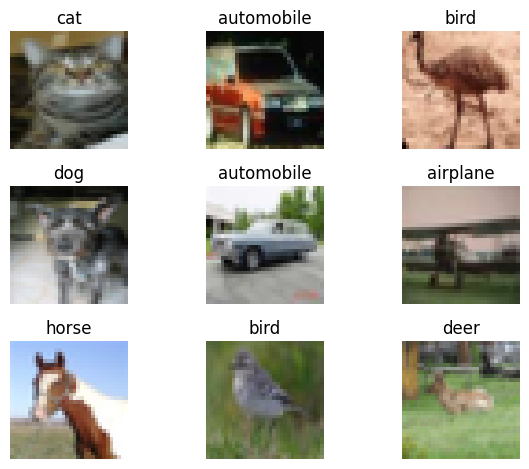

In [4]:
labels={
    0: "airplane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck"
}
def visualize_dataset(imgs):
    fig, axes = plt.subplots(3, 3)
    axes=axes.flatten()
    for i, img in enumerate(imgs):
        axes[i].imshow(img[0].permute(1,2,0)) #H,W,C
        axes[i].axis('off')
        axes[i].set_title(labels[img[1]])
    plt.tight_layout()
    plt.show()

rand_indices=np.random.randint(0,len(train_data),size=9)
rand_imgs=[train_data[i] for i in rand_indices]
visualize_dataset(rand_imgs)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
H=train_data[0][0].shape[1]
W=train_data[0][0].shape[2]

CAT_NUM=10
lr=0.001
batch_size=128
epochs=50

## DataLoader

In [6]:
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Dataset(small)

In [7]:
from cifair import ciFAIR10
train_small_data=ciFAIR10("small-data", 'train0')
test_small_data=ciFAIR10("small-data", 'val0')
print(len(train_small_data))
print(len(test_small_data))

class SmallDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image = torch.tensor(self.images[index], dtype=torch.float32).permute(2,0,1)
        label = torch.tensor(self.labels[index], dtype=torch.long)
        return image, label

train_data=SmallDataset(train_small_data.data,train_small_data.targets)
test_data=SmallDataset(test_small_data.data,test_small_data.targets)

batch_size = 64

train_dataloader_small = DataLoader(
    train_data, batch_size=batch_size, shuffle=True)
test_dataloader_small = DataLoader(
    test_data, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified
300
200


# Dataset (augmented)
- On smaller subset
- random crop
- random rotations
- adding gaussian noise
- different combinations of them

In [8]:
##rand_indices = np.random.randint(0, len(subset), size=9)
#augmented_dataset = augmentingFiles.combined_Augmented_Data(rand_indices)

# CNN model

In [19]:
class CNN(nn.Module):
    def __init__(self,H,W,cat_num):
        super().__init__()
        
        #self.convs=nn.ModuleList([nn.Conv2d(3,16,2,padding=1)]+[nn.Conv2d(i,i*2,3,padding=1) for i in [16,32，64]]) #128
        self.convs=nn.ModuleList([nn.Conv2d(3,32,2,padding=1)]+[nn.Conv2d(i,i*2,3,padding=1) for i in [32,64]])
        self.relu=nn.ReLU()
        self.maxpool=nn.MaxPool2d(2,2)
        self.flatten=nn.Flatten(1,-1)
        self.fc1=nn.Linear(int(128*H*W/(4**3)),256)
        #self.fc2=nn.Linear(256,64)
        self.fc3=nn.Linear(256,cat_num)
        self.dropout=nn.Dropout()
        
        
    def forward(self,x):#x is (batch,channel,H,W)
        for conv in self.convs:
            #print(x.shape)
            x=conv(x)
            
            x=self.relu(x)
            x=self.maxpool(x)
            x=self.dropout(x)
        x=self.flatten(x)
        x=self.dropout(x)
        x=self.relu(self.fc1(x))
        #x=self.relu(self.fc2(x))
        x=self.fc3(x)
        return x


# Training

In [25]:
def train_validation(epochs,train_dataloader,test_dataloader,optimizer,loss_function,model):
    train_losses=[]
    val_losses=[]
    model.to(device)
    for epoch in range(epochs):
        train_loss = 0.0
        val_loss=0.0
        model.train()
        for data in train_dataloader:
            
            #data=data.to(device)
            img,label=data
            img=img.to(device)
            label=label.to(device)
        

            optimizer.zero_grad()
            output = model(img)
            loss = loss_function(output, label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * img.size(0)
        
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(test_dataloader):
                img,label=data
                img=img.to(device)
                label=label.to(device)
                
                output=model(img)
                loss=loss_function(output,label)
                val_loss+=loss.item()*img.size(0)

        #average loss
        train_loss /= len(train_dataloader.dataset)
        val_loss /= len(test_dataloader.dataset)
        train_losses.append(train_loss)
        val_losses.append(val_loss)   
    print(train_losses)
    print(val_losses)     
    plt.semilogy(train_losses, label='Training Loss')
    plt.semilogy(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss curve')
    plt.legend()
    plt.show()



# Result

## Complete dataset (large)
performs well

In [26]:
model=CNN(H,W,CAT_NUM).to(device)
loss_function=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr)

[1.858910287246704, 1.5257693279647828, 1.4137504254913331, 1.3463825687789917, 1.2953115129852295, 1.255119702758789, 1.2180839836502075, 1.1891534101104737, 1.1588962408065795, 1.1457601526641845, 1.1262100654220581, 1.1077252823638917, 1.0997978649902345, 1.0805245737838745, 1.0726108890914916, 1.0534423834609985, 1.0477990149116516, 1.0368841610717774, 1.0316705558395385, 1.0243920532608033, 1.0134527255058288, 1.000494348449707, 0.9937669445800781, 0.9938625067520142, 0.989226768321991, 0.9756465069580078, 0.9714482224655151, 0.9629856895637512, 0.9649540783882141, 0.9585332178878784, 0.9503731643676758, 0.9403467477035522, 0.9473325431632995, 0.9367131935501098, 0.9342933198547363, 0.9275168548965455, 0.9244310087585449, 0.9177875869369507, 0.9133889024734497, 0.9153104852104187, 0.9115925452804565, 0.9081524177932739, 0.8989689524841309, 0.9001023484420776, 0.8911528889656067, 0.8904438006210327, 0.8946144679641723, 0.8901098775863647, 0.8830555059814453, 0.8849590579032898]
[1.

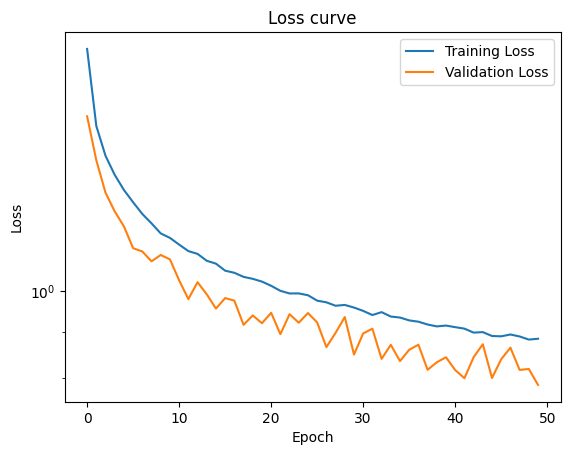

In [27]:
train_validation(epochs,train_dataloader,test_dataloader,optimizer,loss_function,model)

## Small dataset

In [28]:
model_small=CNN(H,W,CAT_NUM).to(device)
loss_function_small=nn.CrossEntropyLoss()
optimizer_small=optim.Adam(model_small.parameters(),lr)

[21.255752283732097, 4.844593620300293, 2.6040292676289876, 2.456851838429769, 2.3439695103963216, 2.3538574536641437, 2.3219963709513345, 2.3023796463012696, 2.2909663168589276, 2.3330091444651284, 2.339093863169352, 2.290636002222697, 2.330754779179891, 2.328817358016968, 2.328979352315267, 2.281468855539958, 2.31677872021993, 2.3117918650309246, 2.3105758571624757, 2.286070152918498, 2.2778217124938966, 2.29160844484965, 2.2847254848480225, 2.2640677865346275, 2.26315881729126, 2.2589042154947916, 2.2722945562998453, 2.2719855372111004, 2.2426077620188396, 2.2276979001363117, 2.2344458611806233, 2.1720464420318604, 2.1674787267049154, 2.175894940694173, 2.137540143330892, 2.09504874865214, 2.091528065999349, 2.093812847137451, 2.0724430592854817, 2.1286306603749594, 2.103282791773478, 2.069870417912801, 2.0013697799046835, 2.0231163183848064, 2.0155774704615275, 1.9118527030944825, 2.0307132895787556, 1.9433522129058838, 1.9421835517883301, 1.8839426120122273]
[2.465939788818359, 2.

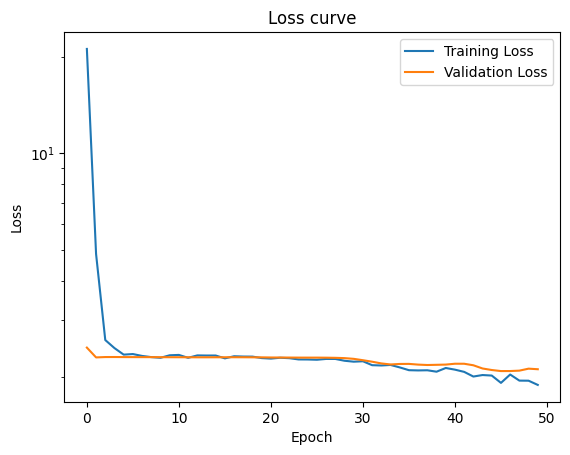

In [29]:
train_validation(epochs,train_dataloader_small,test_dataloader_small,optimizer_small,loss_function_small,model_small)